## Customize Gradcam to "focus" based on agricultural data

Grad cam
https://www.mathworks.com/help/deeplearning/ug/gradcam-explains-why.html

This dataset contains images of the following food items:

fruits- banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
vegetables- cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant.
Content

Data split
train (100 images each)
test (10 images each)
validation (10 images each)
each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present

Access
https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition?resource=download-directory


# 1. Imports

In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Sklearn for metrics and additional tools
from sklearn.metrics import classification_report, confusion_matrix

# Optional: Silence TensorFlow warnings (comment out if you prefer to see TensorFlow warnings)
# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

# Visualization and utility
from keras.utils import plot_model
from termcolor import colored

# Setting styles and suppressing warnings
sns.set_style('darkgrid')

2024-02-19 15:40:07.552084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Preprocess the data

In [2]:
base_dir = 'AgriClassificationData'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


###  Count Data and Classes

Number of classes in train folder: 36
Number of classes in validation folder: 36
Number of classes in test folder: 37


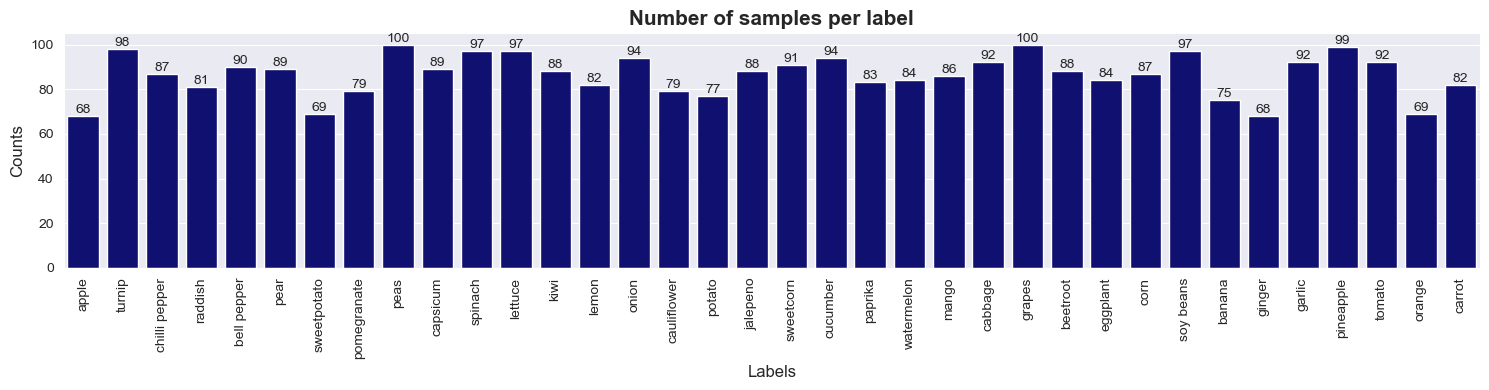

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def num_of_classes(folder_dir, folder_name):
    classes = os.listdir(folder_dir)
    print(f'Number of classes in {folder_name} folder: {len(classes)}')

def plot_samples_per_class(train_dir):
    classes = os.listdir(train_dir)
    count = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in classes]
    
    plt.figure(figsize=(15, 4))
    ax = sns.barplot(x=classes, y=count, color='navy')
    plt.xticks(rotation=90)  # Adjusted for better readability
    ax.bar_label(ax.containers[0])
    plt.title('Number of samples per label', fontsize=15, fontweight='bold')
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.tight_layout()
    plt.show()

num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')
plot_samples_per_class(train_dir)


### Convert Data to a DataFrame

In [4]:
import pandas as pd
import os

def create_df(folder_path):
    all_images = []
    classes = [class_name for class_name in os.listdir(folder_path) if not class_name.startswith('.')]  # Exclude hidden files
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path) if not file_name.startswith('.')])  # Exclude hidden files
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

# Create DataFrames for training, validation, and testing datasets
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

# Display the number of samples in each dataset
print(f'Number of samples in train: {len(train_df)}')
print(f'Number of samples in validation: {len(validation_df)}')
print(f'Number of samples in test: {len(test_df)}')


Number of samples in train: 3115
Number of samples in validation: 351
Number of samples in test: 359


### Example for each class

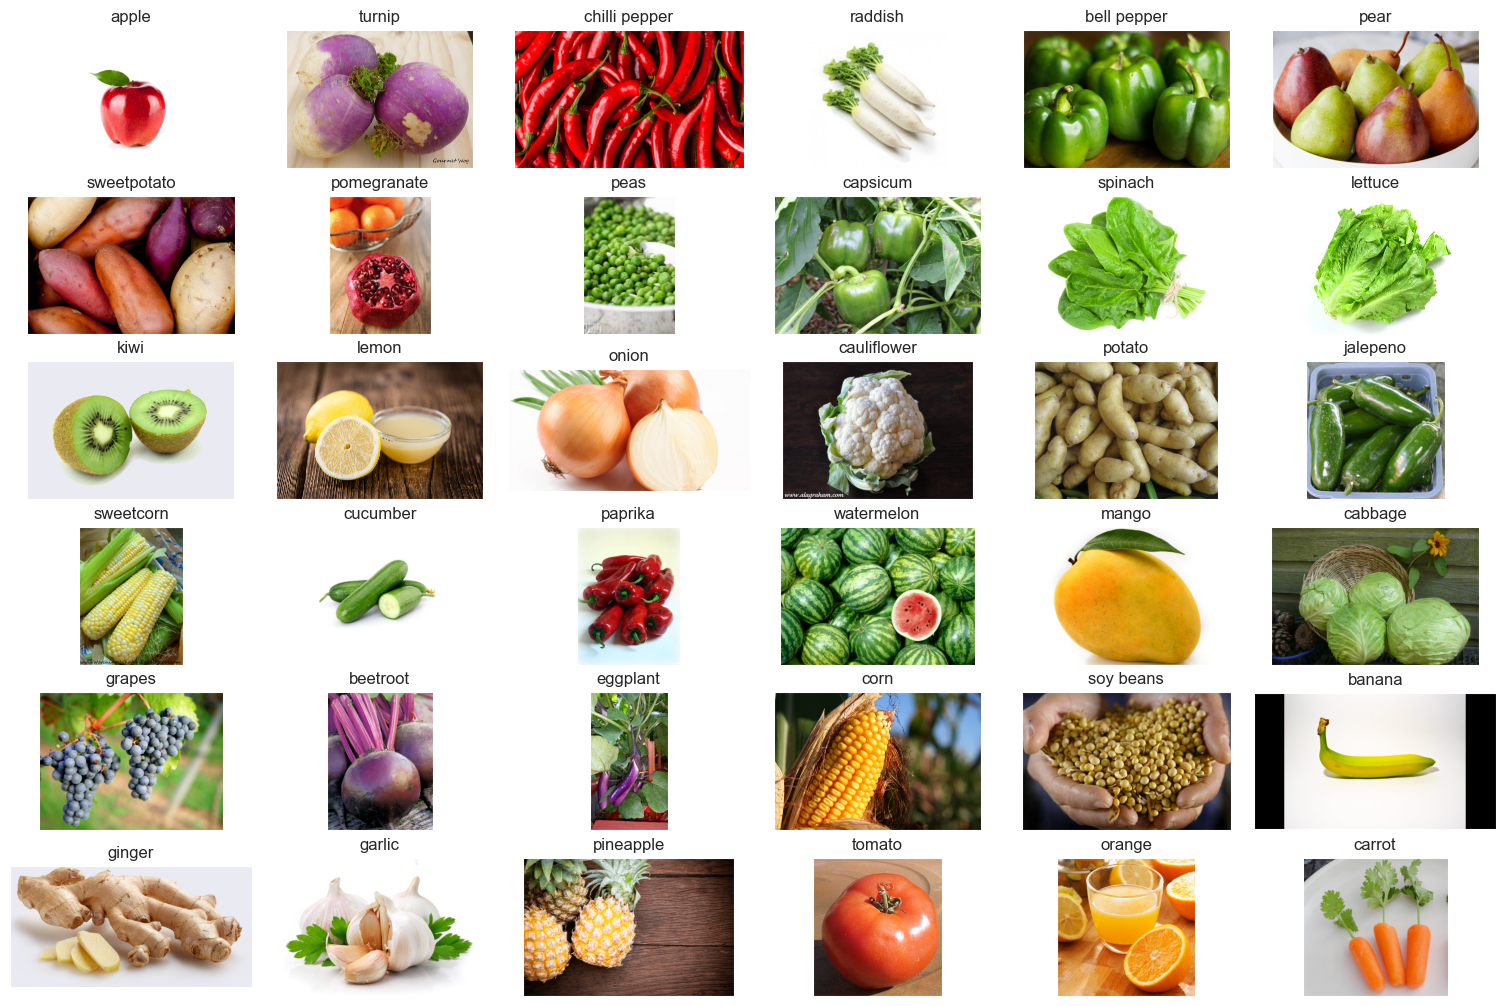

In [5]:
import matplotlib.pyplot as plt

# Create a DataFrame with one label of each category
df_unique = train_df.drop_duplicates(subset=["label"]).reset_index()

# Display some pictures from the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(df_unique.file_path[i])
    ax.imshow(img)
    ax.set_title(df_unique.label[i], fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()


### Data Generators

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# It's good practice to define augmentation parameters at the beginning
augmentation_params = {
    'rescale': 1./255,
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'shear_range': 0.1,
    'fill_mode': 'nearest'
}

# Training Data Generator
train_datagen = ImageDataGenerator(**augmentation_params)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

# Validation Data Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)


Found 3115 validated image filenames belonging to 36 classes.
Found 351 validated image filenames belonging to 36 classes.
Found 359 validated image filenames belonging to 36 classes.


# 3. Build the MobileNetV2 Model


In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load MobileNetV2 without the top layer to use it as a feature extractor
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'  # This applies global average pooling
)

# Make sure the base model is not trainable
base_model.trainable = False

# Add custom layers on top
x = base_model.output
# If you need more custom layers, add them here
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(36, activation='softmax')(x)  # Adjust 36 to the number of classes

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary() #its kinda long, comment out for now

#### Step 3.3: Define the Model Using Functional API?

In [8]:
'''
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

inputs = Input(shape=(224, 224, 3))
x = model(inputs, training=False)  # Use the base model in inference mode
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(36, activation='softmax')(x)

model = Model(inputs, outputs)
'''

"\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Dense, Flatten, Input\n\ninputs = Input(shape=(224, 224, 3))\nx = model(inputs, training=False)  # Use the base model in inference mode\nx = Flatten()(x)\nx = Dense(256, activation='relu')(x)\nx = Dense(128, activation='relu')(x)\noutputs = Dense(36, activation='softmax')(x)\n\nmodel = Model(inputs, outputs)\n"

In [9]:
#Step 3.4: Model Diagram

In [10]:
#plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)


# 4. Test Grad Cam

In [11]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def preprocess_input(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet_v2.preprocess_input(img_array_expanded_dims)

'''
def get_img_array(img_path, size=(224, 224)):
    """
    This function reads an image from the given path and preprocesses it to match
    the input format of the model (e.g., MobileNetV2).
    Parameters:
        img_path (str): The path to the image.
        size (tuple): The target size of the image array (height, width).
    Returns:
        numpy.ndarray: A preprocessed image array.
    """
    # Load the image file, resizing it to the specified size
    img = load_img(img_path, target_size=size)
    # Convert the loaded image to a numpy array
    img_array = img_to_array(img)
    # Expand dimensions to match the model's input format (batch size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array
'''
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()



def display_gradcam_and_heatmap(img_path, heatmap, alpha_heatmap=1, alpha_img=0.5):
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)
    original_img = tf.keras.preprocessing.image.array_to_img(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha_heatmap + img * alpha_img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Plot both original image and heatmap, and the superimposed image
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(jet_heatmap.astype('uint8'))
    plt.title("Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.show()

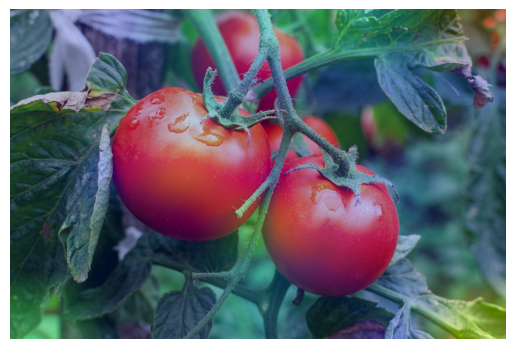

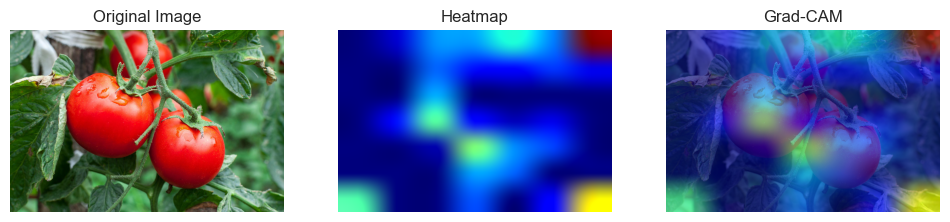

In [12]:
# Specify the path to your image
#img_path = 'image_segmentation_images/test1.jpg'
#img_path = 'AgriClassificationData/test/apple/Image_1.jpg'
#img_path = 'AgriClassificationData/test/apple/Image_4.jpg'
img_path = 'AgriClassificationData/test/tomato/Image_5.jpg'
img_array = preprocess_input(img_path)#get_img_array(img_path, size=(224, 224)))


# Generate the heatmap for a specific class index or the top prediction
heatmap = make_gradcam_heatmap(img_array, model, 'block_16_expand')

# Display the heatmap overlay on the original image
display_gradcam(img_path, heatmap)
display_gradcam_and_heatmap(img_path, heatmap)

# Train the Model

### Callbacks

Custom call back allows us to see how the model starts to focus


In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

class GradCAMCallback(tf.keras.callbacks.Callback):
    def __init__(self, img_path, model, layer_name='block_16_expand', output_dir='grad_cam_images'):
        super(GradCAMCallback, self).__init__()
        self.img_path = img_path
        self.model = model
        self.layer_name = layer_name
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        self.heatmap_imgs = []  # Initialize the list to store heatmap arrays

    def on_epoch_end(self, epoch, logs=None):
        img = load_img(self.img_path, target_size=(224, 224))  # Load and resize the image
        img_array = img_to_array(img)  # Convert the image to an array
        img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to fit the model's expected input
        img_array = preprocess_input(img_array)  # Preprocess the image
        
        # Generate Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(img_array, self.model, self.layer_name)
        self.heatmap_imgs.append(heatmap)  # Append heatmap array to the list
        
        # Generate overlay and save
        superimposed_img = self.generate_overlay(self.img_path, heatmap, epoch)

    def generate_overlay(self, img_path, heatmap, epoch, alpha_heatmap=1, alpha_img=0.5):
        img = load_img(img_path)  # Load the original image
        img = img_to_array(img)  # Convert to array

        # Rescale heatmap to 0-255 and convert to RGB
        heatmap = np.uint8(255 * heatmap)
        jet = plt.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = img_to_array(jet_heatmap)


        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha_heatmap + img *alpha_img
        superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

        # Save the superimposed image
        save_path = os.path.join(self.output_dir, f'epoch_{epoch+1}.jpg')
        superimposed_img.save(save_path)
        #print(f'Grad-CAM saved to: {save_path}')




##When initializing the GradCAMCallback, you now provide an image path to focus on, the model, 
##the specific layer for Grad-CAM, and optionally an output directory where the images will be saved:
grad_cam_callback = GradCAMCallback(
    img_path='AgriClassificationData/test/tomato/Image_5.jpg',  # Update this path
    model=model,
    layer_name='block_16_expand',  # Update if needed
    output_dir='grad_cam_images'  # Directory to save Grad-CAM images
)


#### Sample portion of full training set to train on for fast prototyping

In [14]:
# Sample a fraction of the original dataframe
# Adjust the `frac` value to change the fraction of data used (e.g., 0.1 for 10%)
sampled_train_df = train_df.sample(frac=0.1)

# Verify the size of the sampled dataframex
print(f"Original size: {len(train_df)}, Sampled size: {len(sampled_train_df)}")

# Training Data Generator using the sampled dataframe
train_generator_sampled = train_datagen.flow_from_dataframe(
    dataframe=sampled_train_df,  # Use the sampled DataFrame
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=10,  # You may adjust the batch size if needed
    shuffle=True,
    #seed=42 #if we want it to be the same every time
)


Original size: 3115, Sampled size: 312
Found 312 validated image filenames belonging to 36 classes.


### Start training the model

In [54]:
history = model.fit(
    train_generator, #full train data set all at once
    #train_generator_sampled, #smaller size to prototype quickly
    epochs=100,  # Adjust based on your needs
    validation_data=validation_generator,
    callbacks=[
        checkpoint_cb, 
        earlystop_cb, 
        reduce_lr, 
        grad_cam_callback, #custom
    ]
)

Epoch 1/100
98/98 [==============================] - 152s 2s/step - loss: 1.6874 - accuracy: 0.5429 - val_loss: 0.5075 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 2/100
98/98 [==============================] - 149s 2s/step - loss: 0.7329 - accuracy: 0.7769 - val_loss: 0.3995 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 3/100
98/98 [==============================] - 153s 2s/step - loss: 0.5635 - accuracy: 0.8157 - val_loss: 0.3527 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 4/100
98/98 [==============================] - 152s 2s/step - loss: 0.4448 - accuracy: 0.8523 - val_loss: 0.2628 - val_accuracy: 0.9259 - lr: 0.0010
Epoch 5/100
98/98 [==============================] - 151s 2s/step - loss: 0.3769 - accuracy: 0.8713 - val_loss: 0.2535 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 6/100
98/98 [==============================] - 158s 2s/step - loss: 0.3143 - accuracy: 0.8934 - val_loss: 0.2391 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 7/100
98/98 [==============================] - 156s 2s/step - lo

In [ ]:
#Step 3.8: Plot the Result of Training


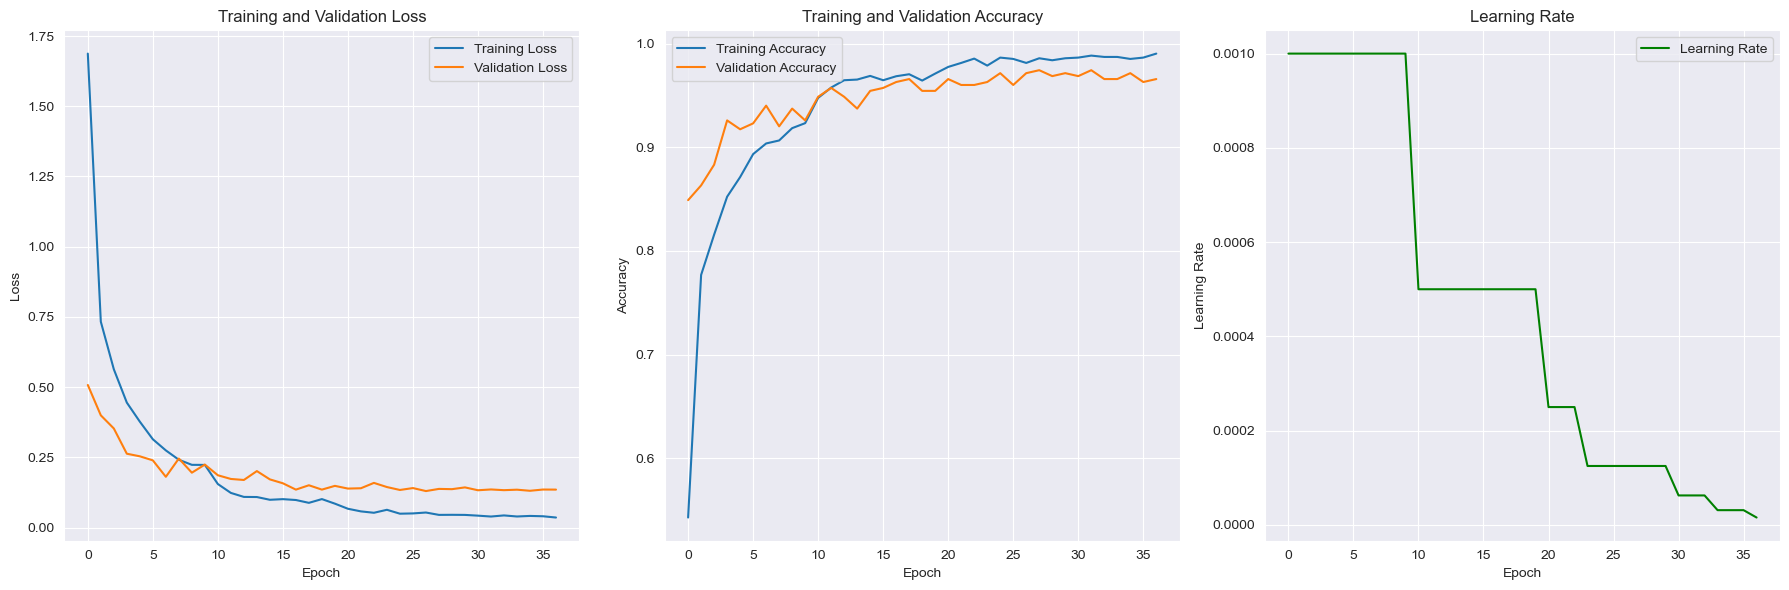

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'history' is the History object returned by the fit method
result_df = pd.DataFrame(history.history)

# Plotting
plt.figure(figsize=(18, 6))

# Plotting training & validation loss
plt.subplot(1, 3, 1)
plt.plot(result_df.loss, label='Training Loss')
plt.plot(result_df.val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 3, 2)
plt.plot(result_df.accuracy, label='Training Accuracy')
plt.plot(result_df.val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Learning Rate
plt.subplot(1, 3, 3)
plt.plot(result_df.lr, label='Learning Rate', color='green')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()


In [55]:
#Step 3.9: Evaluate the Model
# Load the best model saved by ModelCheckpoint callback
best_model = tf.keras.models.load_model('MyModel.keras')

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(test_generator)

print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')


12/12 [==============================] - 17s 1s/step - loss: 0.1274 - accuracy: 0.9721
Test Loss: 0.127
Test Accuracy: 0.972


In [57]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

12/12 [==============================] - 17s 1s/step
               precision    recall  f1-score   support

        apple       0.77      1.00      0.87        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.91      1.00      0.95        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.90      0.90      0.90        10
       carrot       1.00      1.00      1.00        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       0.82      0.90      0.86        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00        10
     jalepeno       0.91      1.00      0.95        10
         ki

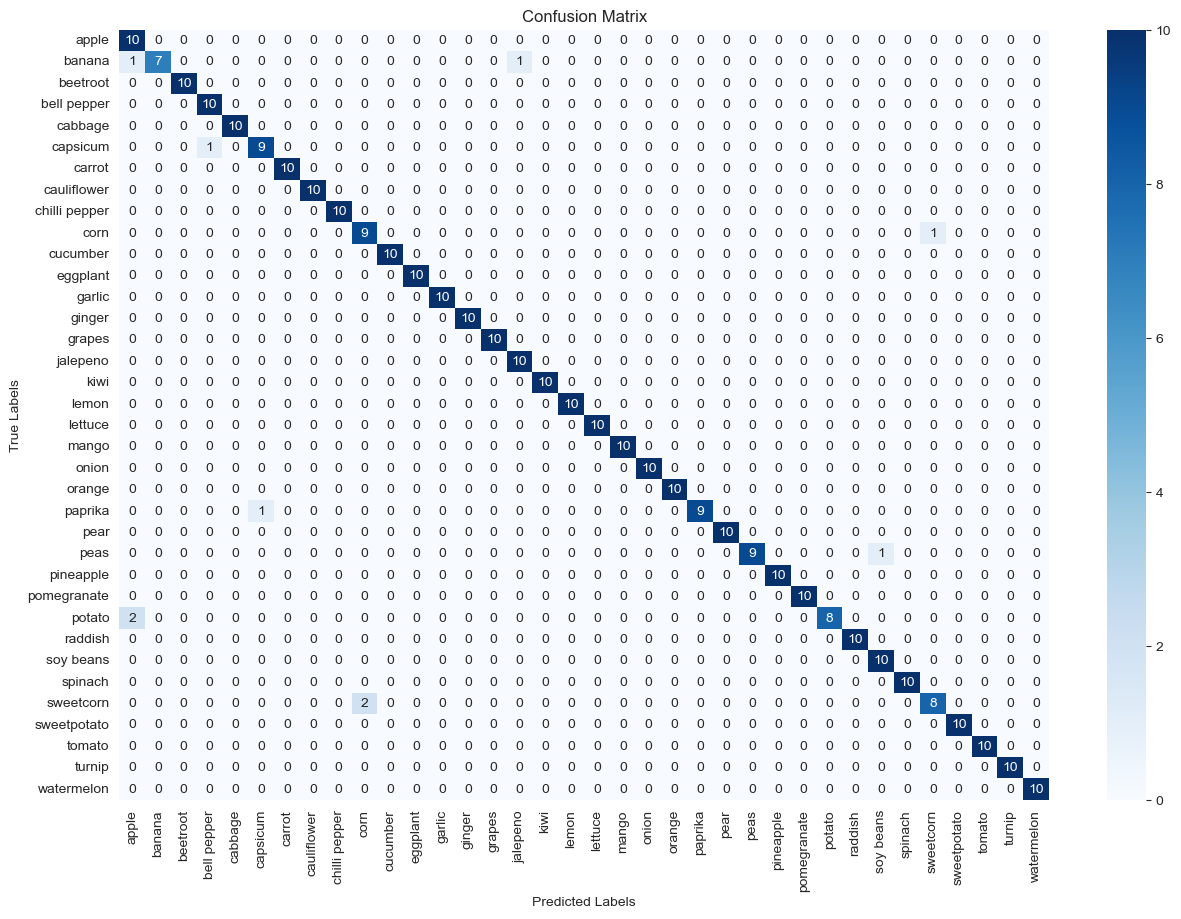

In [58]:
evaluate_model_performance(best_model, test_generator, test_generator.class_indices.keys())

# Step X: Generating a Video from Grad-CAM Images
After training, you'll have a series of Grad-CAM images stored in gradcam_callback.heatmap_imgs. You can use OpenCV to create a video from these images.

### SEE VisualizeGradcamLearning file to do this, can be done seperately, often more convient
